In [3]:
import numpy as np
import keras, sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import shutil
from sklearn.model_selection import train_test_split
import pickle
import os

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3426059514930705174
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11161332826462732566
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [23]:
# data_dir_quakes='/media/peter/data/earthquakenz/data/bloksnorm1/'
# data_dir_noquakes='/media/peter/data/earthquakenz/data/noquakes/bloksnorm1/'
# data_dir_all='/media/peter/data/earthquakenz/data/bloks_all/'
# quake_filenames=os.listdir(data_dir_quakes)
# noquake_filenames=os.listdir(data_dir_noquakes)
# labels =[] #labeled 1 if there is a quake, else 0
# filenames=[] #names of all the files

# for filename in quake_filenames:
#     if filename[-4:]=='.npy':
#         shutil.copy(data_dir_quakes+filename,data_dir_all)
#         labels.append(1)
#         filenames.append(filename)
        
# for filename in noquake_filenames:
#     if filename[-4:]=='.npy':
#         shutil.copy(data_dir_noquakes+filename,data_dir_all)
#         labels.append(0)
#         filenames.append(filename)   
    
# np.save(data_dir_all+'labels.npy',labels)
# np.save(data_dir_all+'filenames.npy',filenames)


In [24]:
keras.__version__, sklearn.__version__, tf.__version__


('2.3.1', '0.23.1', '2.2.0')

In [3]:
data_dir_quakes='/media/peter/data/earthquakenz/data/bloksnorm1/'
data_dir_noquakes='/media/peter/data/earthquakenz/data/noquakes/bloksnorm1/'
data_dir_all='/media/peter/data/earthquakenz/data/bloks_all/'
filenames=np.load(data_dir_all+'filenames.npy')
labels=np.load(data_dir_all+'labels.npy')
# labels=keras.utils.to_categorical(labels)

In [13]:
filenames_shuffled, labels_shuffled = sklearn.utils.shuffle(filenames,labels)

In [5]:
X_train_filenames, X_val_filenames, y_train, y_val=train_test_split(filenames_shuffled, labels_shuffled, 
                                                                   test_size=0.2,random_state=42)

In [6]:
X_train_filenames

array(['2019p258188.npy', '2018p584659.npy', '1539713539.95.npy', ...,
       '1538155240.77.npy', '1448827549.93.npy', '1502864402.99.npy'],
      dtype='<U17')

In [7]:
len(y_train),len(y_val)

(1523, 381)

In [8]:

class blok_Generator(keras.utils.Sequence) :

    def __init__(self, blok_filenames, labels, batch_size) :
        self.blok_filenames = blok_filenames
        self.labels = labels
        self.batch_size = batch_size


    def __len__(self) :
        print('calling len')
        return (np.ceil(len(self.blok_filenames) / float(self.batch_size))).astype(np.int)


    def __getitem__(self, idx) :
        batch_x = self.blok_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        data_dir_all='/media/peter/data/earthquakenz/data/bloks_all/'

        return np.array([np.reshape(np.load(data_dir_all+file_name),(3000,3*58,1)) for file_name in batch_x]),np.array(batch_y)

#     return np.array([np.load(data_dir_all+file_name) for file_name in batch_x]),np.array(batch_y)
#     return np.array([
#             resize(imread('/content/all_images/' + str(file_name)), (80, 80, 3))
#                for file_name in batch_x])/255.0, np.array(batch_y)

In [8]:
blok1,y1=training_batch_generator.__getitem__(0)
plt.figure(figsize=(24,9))
plt.imshow(blok1[3,::,:,0].T,aspect='auto',interpolation='none')
plt.colorbar()
print(y1)

NameError: name 'training_batch_generator' is not defined

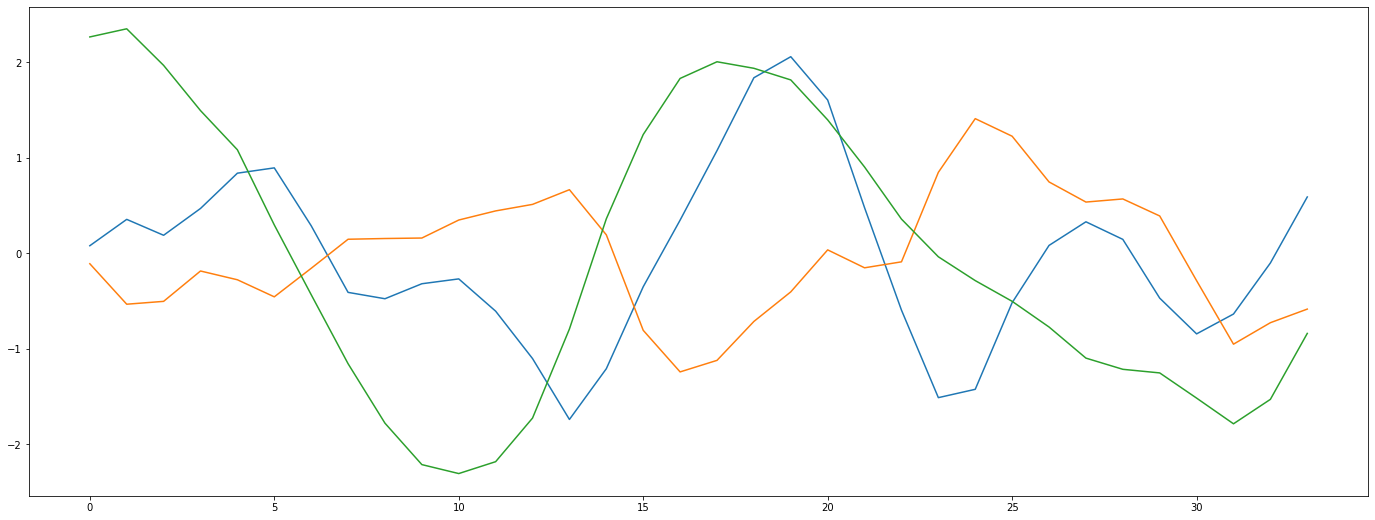

In [151]:
plt.figure(figsize=(24,9))

plt.plot(blok1[3,100:200:3,0:3,0])

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,SeparableConv2D,DepthwiseConv2D,Conv1D


https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71

In [10]:
batch_size=16

training_batch_generator=blok_Generator(X_train_filenames,y_train,batch_size)
validation_batch_generator=blok_Generator(X_val_filenames,y_val,batch_size)
# input_shape=(batch_size,3000,3,58) #np.load(data_dir_all+noquake_filenames[0]).shape
input_shape=(3000,3*58) #np.load(data_dir_all+noquake_filenames[0]).shape

In [11]:
len(training_batch_generator)

calling len


96

In [12]:
def create_QCNN():
    model = Sequential()
    
    model.add(DepthwiseConv2D(kernel_size=(10,3),depth_multiplier=3))
    model.add(SeparableConv2D(filters=128,kernel_size=(10,3),padding='valid',input_shape=input_shape,activation ='relu'))
    model.add(BatchNormalization(axis=-3))
    model.add(SeparableConv2D(filters=128,kernel_size=(10,3),padding='valid',input_shape=input_shape,activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,3)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation = "relu")) #Fully connected layer
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

#     model.add(Dense(12,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam')
    print('Model Compiled')
    
    return model

In [13]:
model_QCNN=create_QCNN()
# model_QCNN.summary()

Model Compiled


In [14]:
epochs=2
model_CNN.fit_generator(gen)

NameError: name 'model_CNN' is not defined

In [15]:
3800/16

237.5

In [16]:

keras.backend.image_data_format()

'channels_last'

In [17]:
blok_nq1=np.load(data_dir_all+noquake_filenames[0])
blok_q1=np.load(data_dir_all+quake_filenames[0])

NameError: name 'noquake_filenames' is not defined

In [18]:
blok_nq1.shape

NameError: name 'blok_nq1' is not defined

In [19]:
blok_q1.shape

NameError: name 'blok_q1' is not defined

In [11]:
input_shape=(3000,58*3,1)

In [21]:
model = Sequential()

model.add(Conv2D(filters=64,kernel_size=(15,3),strides=(1,3),input_shape=input_shape,activation ='relu'
                          ,padding='valid'))

model.add(MaxPooling2D(pool_size=(3,3)))
model.add(BatchNormalization(axis=3))

# model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(3,3)
#                           ,activation ='relu',padding='valid'))

model.add(SeparableConv2D(filters=32,kernel_size=(10,1),padding='valid',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

model.add(SeparableConv2D(filters=32,kernel_size=(10,1),padding='valid',activation ='relu'))
#,input_shape=input_shape,activation ='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(SeparableConv2D(filters=32,kernel_size=(10,3),padding='valid'))
#,input_shape=input_shape,activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(32, activation = "relu")) #Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(32, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(256, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Dense(64, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.4))


# opt = keras.optimizers.Adam(learning_rate=0.003)
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives(),tf.keras.metrics.FalsePositives()])
print('Model Compiled')

Model Compiled


In [32]:
model = Sequential()



model.add(Conv2D(filters=12,kernel_size=(3,3),strides=(1,3),input_shape=input_shape,activation ='relu'
                          ,padding='valid'))
# model.add(Conv2D(filters=12,kernel_size=(10,1),strides=(4,1),input_shape=input_shape,activation ='relu'
#                           ,padding='valid'))
model.add(MaxPooling2D(pool_size=(3,1)))

model.add(Conv2D(filters=10,kernel_size=(15,1),strides=(5,1),activation ='relu'
                          ,padding='valid'))
model.add(MaxPooling2D(pool_size=(12,1))) #used to be 12
model.add(BatchNormalization(axis=3))

# model.add(Conv2D(filters=20,kernel_size=(6,1),strides=(3,1)
#                           ,activation ='relu',padding='valid'))

# model.add(SeparableConv2D(filters=2,kernel_size=(10,1),padding='valid',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(SeparableConv2D(filters=32,kernel_size=(10,3),padding='valid',activation ='relu'))
#,input_shape=input_shape,activation ='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(SeparableConv2D(filters=32,kernel_size=(10,3),padding='valid'))
#,input_shape=input_shape,activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation = "relu")) #Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) #Fully connected layer
model.add(Dense(128, activation = "relu")) #Fully connected layer

model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(64, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.4))


opt = keras.optimizers.Adam(learning_rate=0.003)
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
print('Model Compiled')

Model Compiled


In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2998, 58, 12)      120       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 999, 58, 12)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 197, 58, 10)       1810      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 58, 10)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 58, 10)        40        
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 58, 10)        40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 9280)             

In [43]:
y_val.shape

(381,)

In [ ]:
model_history=model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=int(1523//batch_size),
                    epochs=100,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=int(381//batch_size),
                    use_multiprocessing=True,
                    workers=10)
model.save("model_save12.hdf5")

with open('model_history_save12.pkl', 'wb') as file_pi:
    pickle.dump(model_history, file_pi)

calling len
calling len
calling len
Epoch 1/100
95/95 [==============================] - 71s 745ms/step - loss: 0.6841 - binary_accuracy: 0.5155 - recall_3: 0.6577 - precision_3: 0.5300 - val_loss: 0.7577 - val_binary_accuracy: 0.5167 - val_recall_3: 0.6763 - val_precision_3: 0.5196
Epoch 2/100
calling len
Epoch 1/100
94/95 [============================>.] - ETA: 0s - loss: 0.6318 - binary_accuracy: 0.5516 - recall_3: 0.6552 - precision_3: 0.5491calling len
Epoch 1/100
95/95 [==============================] - 70s 740ms/step - loss: 0.6314 - binary_accuracy: 0.5518 - recall_3: 0.6549 - precision_3: 0.5493 - val_loss: 1.4118 - val_binary_accuracy: 0.5655 - val_recall_3: 0.6424 - val_precision_3: 0.5616
Epoch 3/100
95/95 [==============================] - 72s 761ms/step - loss: 0.5541 - binary_accuracy: 0.5886 - recall_3: 0.6545 - precision_3: 0.5833 - val_loss: 0.8788 - val_binary_accuracy: 0.6043 - val_recall_3: 0.6351 - val_precision_3: 0.6025
Epoch 4/100
95/95 [=======================

In [ ]:
model = Sequential()



model.add(Conv2D(filters=12,kernel_size=(3,3),strides=(1,3),input_shape=input_shape,activation ='relu'
                          ,padding='valid'))
# model.add(Conv2D(filters=12,kernel_size=(10,1),strides=(4,1),input_shape=input_shape,activation ='relu'
#                           ,padding='valid'))
model.add(MaxPooling2D(pool_size=(3,1)))

model.add(Conv2D(filters=10,kernel_size=(15,1),strides=(5,1),activation ='relu'
                          ,padding='valid'))
model.add(MaxPooling2D(pool_size=(3,1))) #used to be 12
model.add(BatchNormalization(axis=3))

# model.add(Conv2D(filters=20,kernel_size=(6,1),strides=(3,1)
#                           ,activation ='relu',padding='valid'))

# model.add(SeparableConv2D(filters=2,kernel_size=(10,1),padding='valid',activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(SeparableConv2D(filters=32,kernel_size=(10,3),padding='valid',activation ='relu'))
#,input_shape=input_shape,activation ='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(SeparableConv2D(filters=32,kernel_size=(10,3),padding='valid'))
#,input_shape=input_shape,activation ='relu'))
# model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation = "relu")) #Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) #Fully connected layer
model.add(Dense(128, activation = "relu")) #Fully connected layer

model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Dense(128, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(64, activation = "relu")) #Fully connected layer
# model.add(BatchNormalization())
# model.add(Dropout(0.4))


opt = keras.optimizers.Adam(learning_rate=0.003)
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt,
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
print('Model Compiled')

model_history=model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=int(1523//batch_size),
                    epochs=100,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=int(381//batch_size),
                    use_multiprocessing=True,
                    workers=10)
model.save("model_save3.hdf5")

with open('model_history_save3.pkl', 'wb') as file_pi:
    pickle.dump(model_history, file_pi)

In [14]:
aa='honhon'
with open('model_history_save_test1.pkl', 'wb') as file_pi:
    pickle.dump(aa, file_pi)


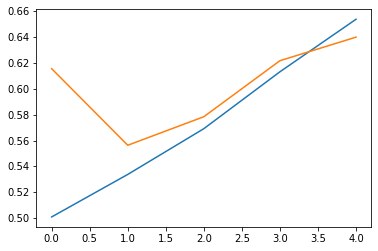

In [112]:
plt.plot(model_history.epoch,model_history.history['val_precision_12'])
plt.plot(model_history.epoch,model_history.history['val_recall_12'])

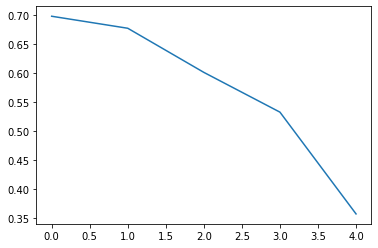

In [113]:
plt.plot(model_history.epoch,model_history.history['loss'])

In [111]:
model_history.history


{'binary_accuracy': [0.5025586, 0.5142567, 0.5543959, 0.5916083, 0.6332656],
 'loss': [0.6976399206925324,
  0.6769760863703453,
  0.6011156842814587,
  0.5327409149392655,
  0.357749856599523],
 'precision_12': [0.49823308, 0.520555, 0.5602081, 0.59444386, 0.6368379],
 'recall_12': [0.34750676, 0.59706193, 0.5620676, 0.6048332, 0.6345294],
 'val_binary_accuracy': [0.49603280425071716,
  0.5308449268341064,
  0.5664828419685364,
  0.6119688749313354,
  0.6476745009422302],
 'val_loss': [0.6932775974273682,
  0.7275683283805847,
  1.2046637535095215,
  1.076835036277771,
  1.2294230461120605],
 'val_precision_12': [0.5009819269180298,
  0.5338302254676819,
  0.5691888928413391,
  0.6131569743156433,
  0.6537613868713379],
 'val_recall_12': [0.6155487298965454,
  0.5563664436340332,
  0.5784309506416321,
  0.6217253804206848,
  0.6399308443069458]}

In [15]:
with open("model_history_save12_3.pkl", "rb") as f:
    model_history1 = pickle.load(f)
    
    


In [16]:
model_history1.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision', 'loss', 'binary_accuracy', 'recall', 'precision'])

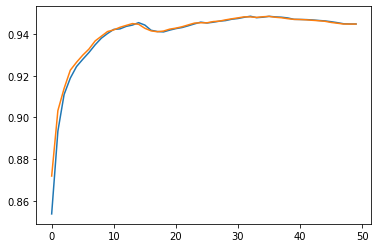

In [25]:
plt.plot(model_history1['binary_accuracy'])
plt.plot(model_history1['val_binary_accuracy'])


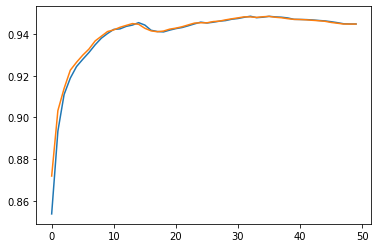

In [19]:
plt.plot(model_history1['binary_accuracy'])
plt.plot(model_history1['val_binary_accuracy'])


In [21]:
def f1score(P,R):
    P=np.array(P)
    R=np.array(R)
    return 2*P*R/(P+R)

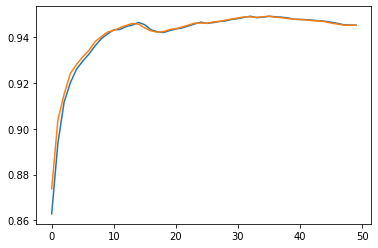

In [26]:
plt.plot(f1score(model_history1['precision'],model_history1['recall']))
plt.plot(f1score(model_history1['val_precision'],model_history1['val_recall']))

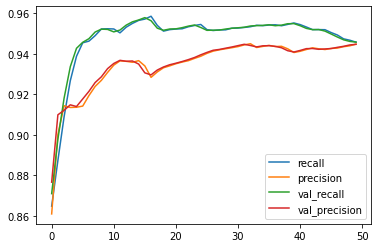

In [31]:
plt.plot(model_history1['recall'])
plt.plot(model_history1['precision'])
plt.plot(model_history1['val_recall'])
plt.plot(model_history1['val_precision'])
plt.legend(['recall','precision','val_recall','val_precision'])


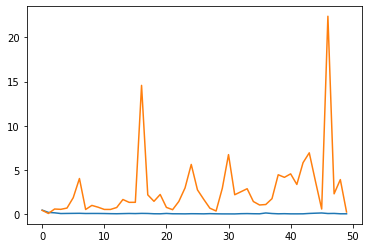

In [30]:
plt.plot(model_history1['loss'])
plt.plot(model_history1['val_loss'])


In [34]:
item = np.load("model_history_save12.pkl",allow_pickle=True).item()


OSError: Failed to interpret file 'model_history_save12.pkl' as a pickle

In [82]:
model1 = keras.models.load_model('model_save12_2')

ValueError: Unknown metric function: {'class_name': 'BinaryAccuracy', 'config': {'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}}

In [83]:
binary_accuracy=tf.keras.metrics.BinaryAccuracy()
model = keras.models.load_weights('model_save12_2')


AttributeError: module 'keras.models' has no attribute 'load_weights'

In [30]:
tf.keras.metrics.BinaryAccuracy()

In [85]:
model.load_weights('model_save12_2')

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2998, 58, 12)      120       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 999, 58, 12)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 197, 58, 10)       1810      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 58, 10)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 58, 10)        40        
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 58, 10)        40        
_________________________________________________________________
flatten_2 (Flatten)          (None, 9280)             

In [96]:
(model.get_weights())

[array([[[[-0.04371445,  0.06288289,  0.00220832, -0.26536834,
            0.12732619, -0.20944123, -0.12803116, -0.33021167,
            0.10915013,  0.21212925, -0.07018335, -0.0819506 ]],
 
         [[ 0.17572783, -0.12219331,  0.16629668,  0.06106441,
            0.02912835,  0.31213728,  0.07308736,  0.17912923,
           -0.25181496, -0.02450743, -0.04187294, -0.32787195]],
 
         [[-0.22734806, -0.10240284, -0.24564868, -0.08502728,
           -0.05675149,  0.0831949 ,  0.16702476, -0.0327068 ,
           -0.13656875,  0.23316926,  0.12352274, -0.38357523]]],
 
 
        [[[-0.2205665 , -0.32504475, -0.10789263, -0.00963788,
            0.09203134, -0.01728389,  0.10230468, -0.2572895 ,
           -0.187482  , -0.08749034, -0.15503348, -0.0700805 ]],
 
         [[-0.01902578, -0.34224388,  0.12009176,  0.21555546,
           -0.3173343 ,  0.287467  , -0.19546221, -0.07277993,
            0.17058784,  0.04998314, -0.38171408, -0.08736391]],
 
         [[-0.0813356 ,  0.30558

In [98]:
model_history=model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=int(1523//batch_size),
                    epochs=2,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=int(381//batch_size),
                    use_multiprocessing=True,
                    workers=10)

calling len
calling len
calling len
Epoch 1/2
95/95 [==============================] - 84s 881ms/step - loss: 0.4436 - binary_accuracy: 0.8505 - recall_1: 0.8569 - precision_1: 0.8462 - val_loss: 0.4126 - val_binary_accuracy: 0.8623 - val_recall_1: 0.8738 - val_precision_1: 0.8555
Epoch 2/2
calling len
95/95 [==============================] - 82s 862ms/step - loss: 0.2221 - binary_accuracy: 0.8841 - recall_1: 0.8955 - precision_1: 0.8775 - val_loss: 0.5729 - val_binary_accuracy: 0.8870 - val_recall_1: 0.9040 - val_precision_1: 0.8750


In [104]:
model_history.


AttributeError: 'History' object has no attribute 'keys'

In [14]:
data_dir_quakes='/media/peter/data/earthquakenz/data/new_data/test_data/quakes/bloksnorm1/'
data_dir_noquakes='/media/peter/data/earthquakenz/data/new_data/test_data/noquakes/bloksnorm1/'
data_dir_all='/media/peter/data/earthquakenz/data/new_data/test_data/bloks_all/'
quake_filenames=os.listdir(data_dir_quakes)
noquake_filenames=os.listdir(data_dir_noquakes)
labels =[] #labeled 1 if there is a quake, else 0
filenames=[] #names of all the files

for filename in quake_filenames:
    if filename[-4:]=='.npy':
        shutil.copy(data_dir_quakes+filename,data_dir_all)
        labels.append(1)
        filenames.append(filename)
        
for filename in noquake_filenames:
    if filename[-4:]=='.npy':
        shutil.copy(data_dir_noquakes+filename,data_dir_all)
        labels.append(0)
        filenames.append(filename)   
    
np.save(data_dir_all+'labels.npy',labels)
np.save(data_dir_all+'filenames.npy',filenames)


In [5]:
data_dir_quakes


'/media/peter/data/earthquakenz/data/newdata/quakes/bloksnorm1/'

In [8]:
data_dir_all='/media/peter/data/earthquakenz/data/new_data/bloks_all/'

filenames=np.load(data_dir_all+'filenames.npy')
labels=np.load(data_dir_all+'labels.npy')

In [9]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [10]:
filenames

array(['2017p777334.npy', '2013p448674.npy', '2013p474091.npy', ...,
       '1530770909.32.npy', '1532246097.64.npy', '1533098724.47.npy'],
      dtype='<U17')

In [11]:
filenames_shuffled, labels_shuffled = sklearn.utils.shuffle(filenames,labels)
X_train_filenames, X_val_filenames, y_train, y_val=train_test_split(filenames_shuffled, labels_shuffled,
                                                                   test_size=0.2,random_state=1)

In [12]:
X_train_filenames,y_train

(array(['1461287166.63.npy', '1486733296.21.npy', '2016p741634.npy', ...,
        '1445193187.49.npy', '2018p621732.npy', '1440017142.96.npy'],
       dtype='<U17'), array([0, 0, 1, ..., 0, 1, 0]))